In [45]:
#IMPORT LIBRARIES
import gymnasium as gym
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [46]:
df = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\FinRL\data\AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-28,43.580002,43.727501,43.230000,43.287498,41.672825,112861600
1,2019-03-01,43.570000,43.787498,43.222500,43.742500,42.110855,103544800
2,2019-03-04,43.922501,44.437500,43.492500,43.962502,42.322651,109744800
3,2019-03-05,43.985001,44.000000,43.634998,43.882500,42.245636,78949600
4,2019-03-06,43.667500,43.872501,43.485001,43.630001,42.002560,83241600


In [47]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [48]:
df.sort_values('Date', ascending=True, inplace=True)
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-28,43.580002,43.727501,43.230000,43.287498,41.672825,112861600
2019-03-01,43.570000,43.787498,43.222500,43.742500,42.110855,103544800
2019-03-04,43.922501,44.437500,43.492500,43.962502,42.322651,109744800
2019-03-05,43.985001,44.000000,43.634998,43.882500,42.245636,78949600
2019-03-06,43.667500,43.872501,43.485001,43.630001,42.002560,83241600


In [49]:
env = gym.make('stocks-v0', df=df, frame_bound=(20, 1000), window_size=20)

c:\Users\abhis\Anaconda3\envs\env\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 2)
  logger.warn(


info: {'total_reward': 108.78485870361328, 'total_profit': 0.08121937514201717, 'position': <Positions.Short: 0>}


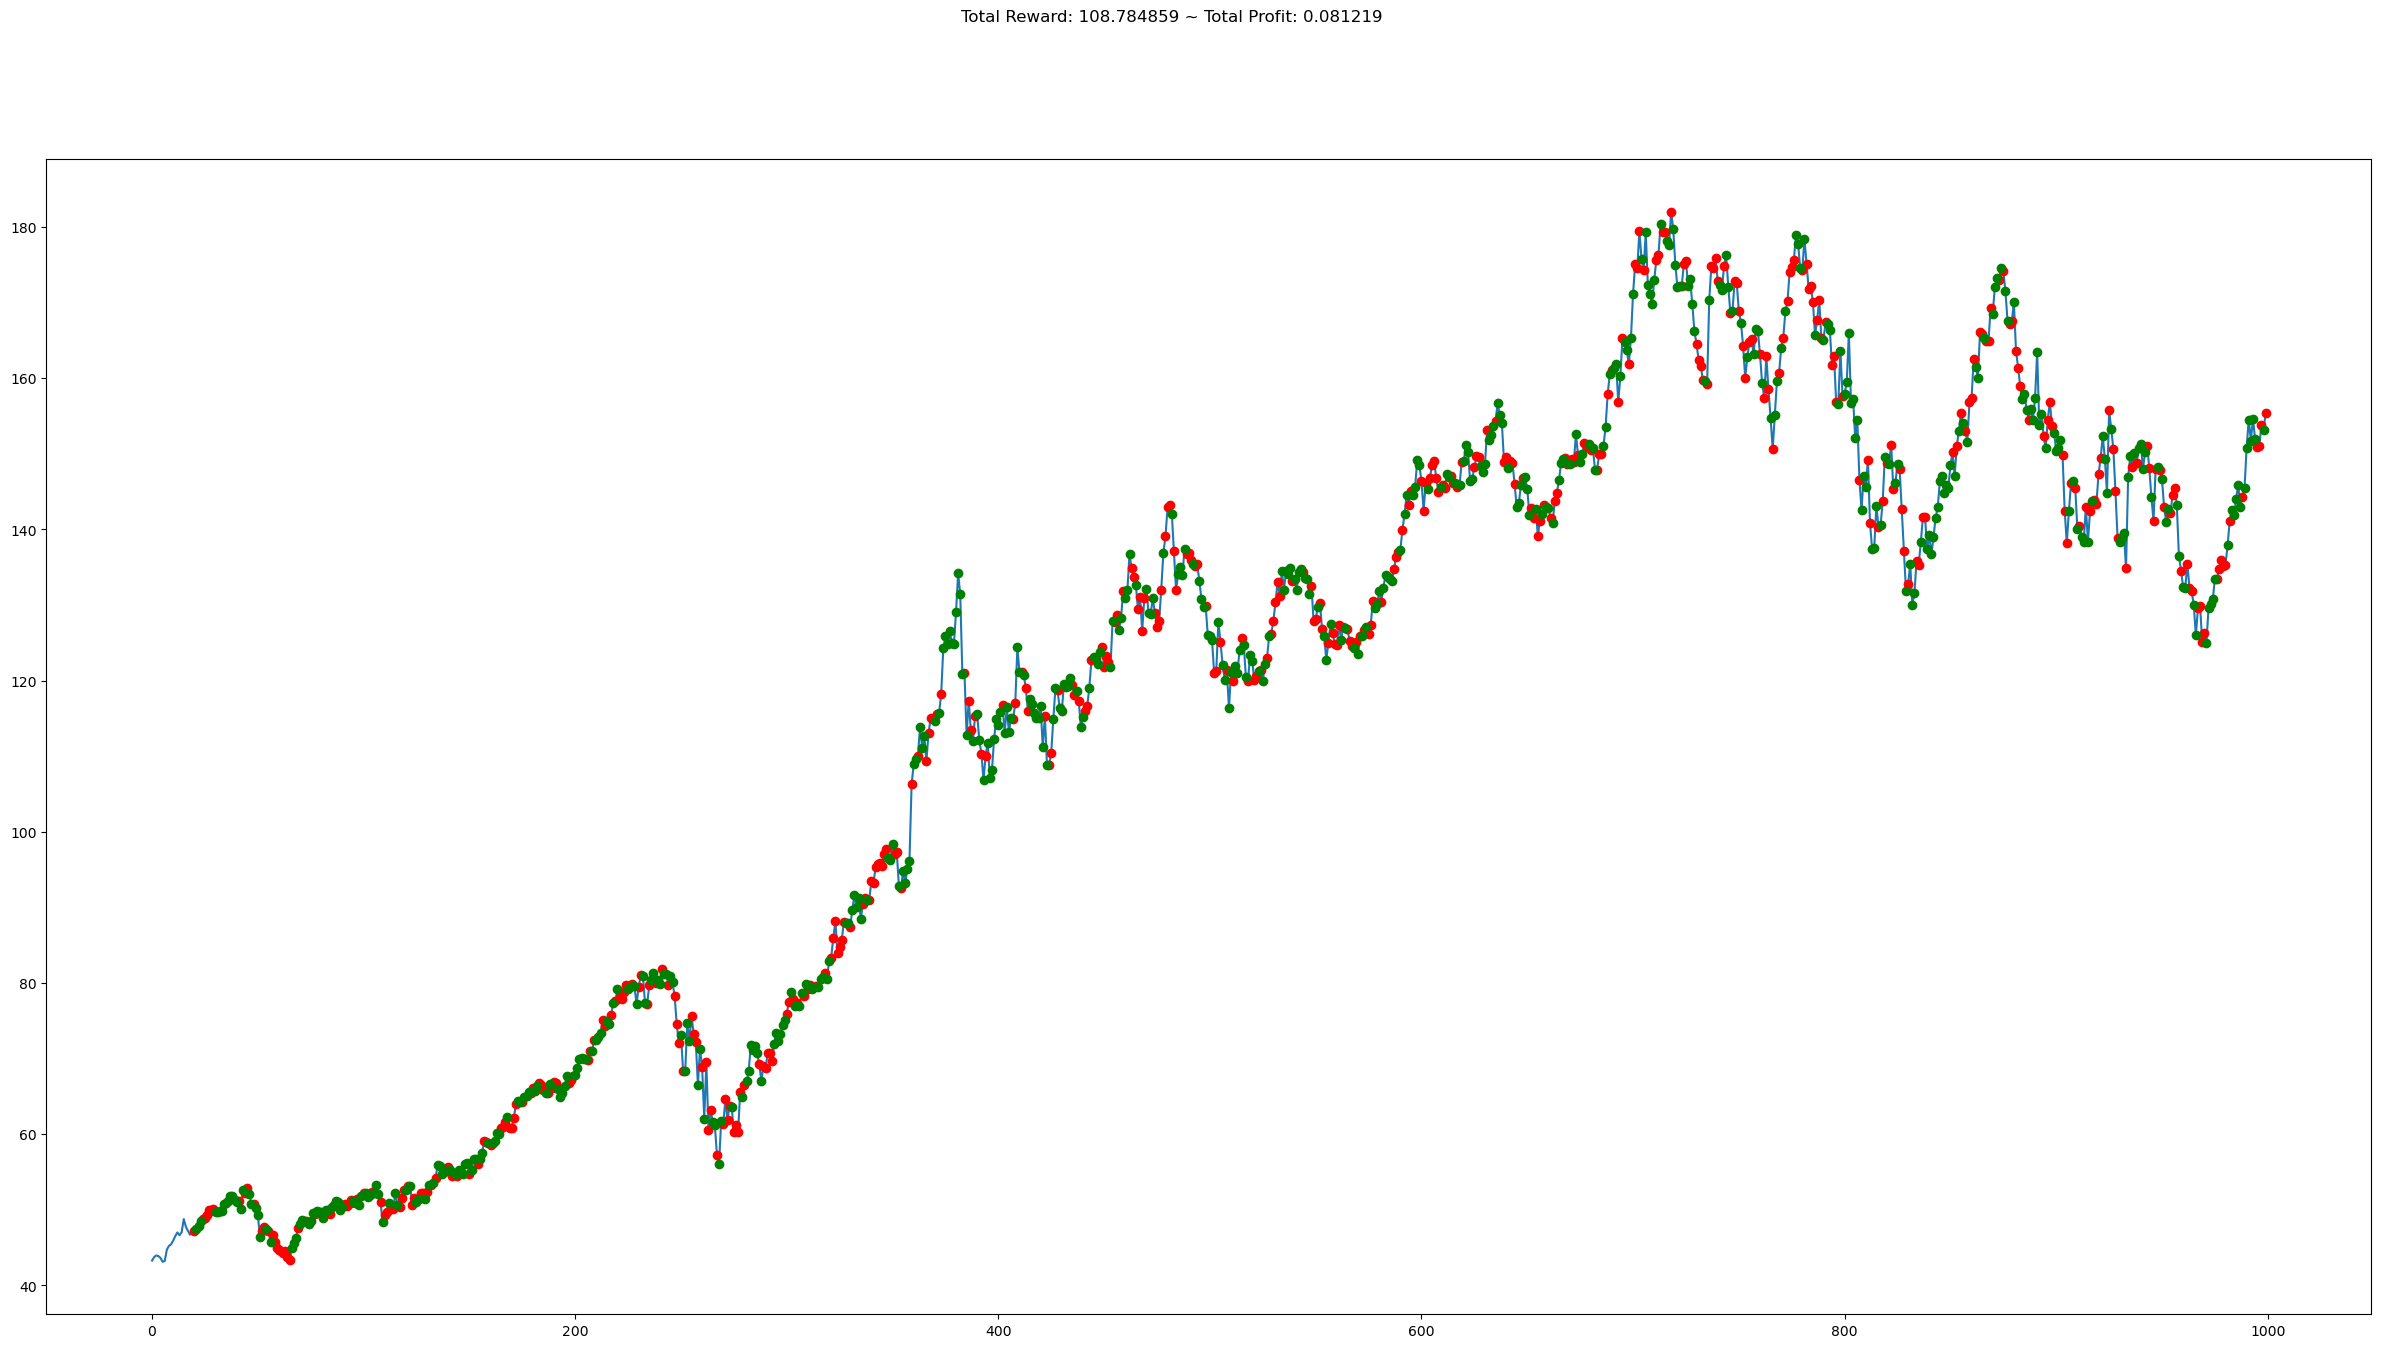

In [50]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break
plt.figure(figsize=(30, 15))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [51]:
df['Volume'] = df['Volume'].astype(float)
df['SMA'] = TA.SMA(df, 20)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

df.fillna(0, inplace=True)

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [52]:
class CustomTradingEnv(StocksEnv):
    _process_data = add_signals

#CREATE UPDATED STOCK ENV
env2 = CustomTradingEnv(df=df, window_size=12, frame_bound=(20, 1000))
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [53]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=250_000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 442      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.58    |
|    explained_variance | 0.167    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.1      |
|    value_loss         | 8.63     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 441      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -0.714   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.135    |
|    value_loss     

In [57]:
env = CustomTradingEnv(df=df, window_size=12, frame_bound=(1000, 1250))
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 0.0, 'total_profit': 1.189098315453327, 'position': <Positions.Long: 1>}


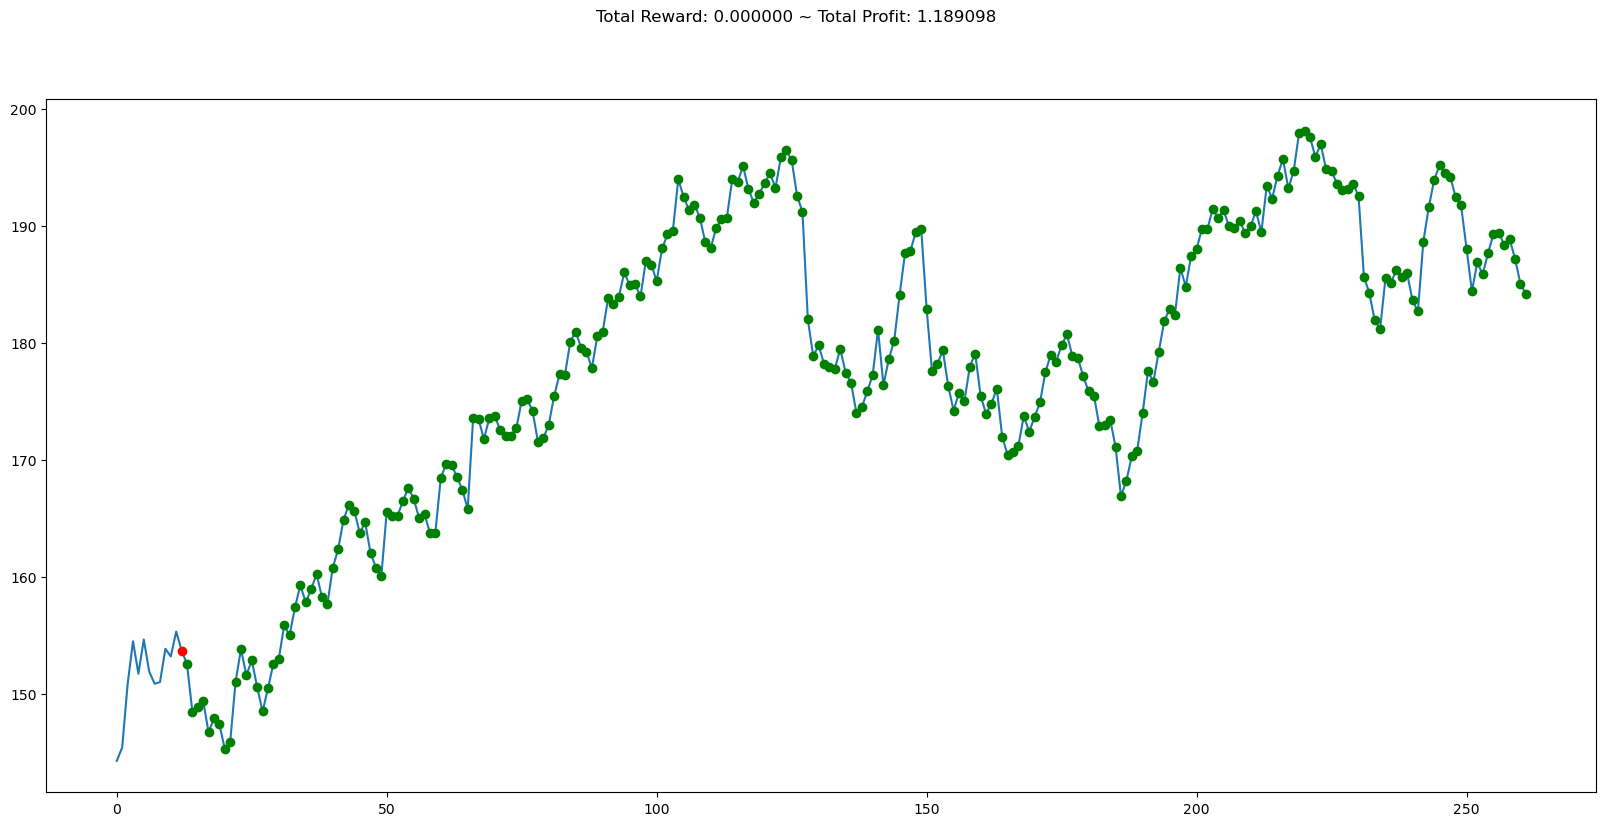

In [55]:
plt.figure(figsize=(20, 9))
plt.cla()
env.render_all()
plt.show()